#**Classification**

###Imports required packages

In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, \
    f1_score, precision_recall_curve, roc_curve, roc_auc_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

###Retrieving & Analyzing the Data

In [2]:
mnist = fetch_openml("mnist_784", as_frame=False)

In [ ]:
# Checks the available bunch objects
print(mnist.keys())

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


###Exploratory Data Analysis (EDA)


In [4]:
# Finds the shape of the data
print(mnist.data.shape)

(70000, 784)


In [5]:
# Similarly, finds the shape of the target
print(mnist.target.shape)

(70000,)


In [6]:
# Let's view target of first few observations
print(mnist.target[:20])

['5' '0' '4' '1' '9' '2' '1' '3' '1' '4' '3' '5' '3' '6' '1' '7' '2' '8'
 '6' '9']


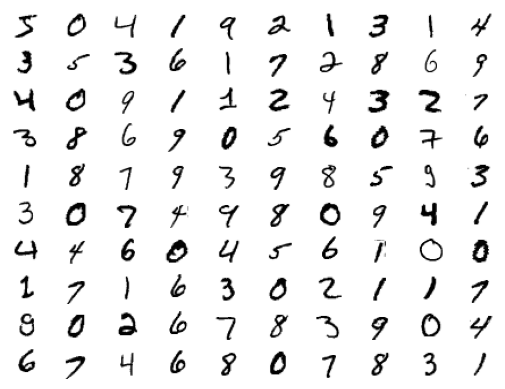

In [7]:
# Let's plot first 100 handwritten digits in a 10x10 subplots in a figure

for idx, image_data in enumerate(mnist.data[:100]):
    plt.subplot(10, 10, idx + 1)
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

plt.show()

###Modeling a Binary Classifier

In [8]:
# Converts target type from 'char' to 'integer'
mnist.target = mnist.target.astype(int)

In [9]:
# Creates binary vector for target - True for all 5s and False for all other digits
y_5 = (mnist.target == 5)

print(y_5)

[ True False False ... False  True False]


In [10]:
# Split the data set into train and test data set.
X_train, X_test, y_train_5, y_test_5 = \
    mnist.data[:60000], mnist.data[60000:], y_5[:60000], y_5[60000:]

In [11]:
# Initialize the classifier
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

# Fits the model on the train set
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(n_jobs=-1, random_state=42)

##Measuring Model Performance

####Measuring Out-of-Sample Accuracy Score

In [12]:
sgd_clf_predictions_train = sgd_clf.predict(X_train)
sgd_clf_accuracy_train = accuracy_score(y_train_5, sgd_clf_predictions_train)

sgd_clf_predictions_test = sgd_clf.predict(X_test)
sgd_clf_accuracy_test = accuracy_score(y_test_5, sgd_clf_predictions_test)

print("SGD Classifier Classification Accuracy: \n{:.3f} [Train], \n{:.3f} [Test]".format(
    sgd_clf_accuracy_train, sgd_clf_accuracy_test))

SGD Classifier Classification Accuracy: 
0.952 [Train], 
0.949 [Test]


####Measuring Accuracy Score Over Cross-Validation

In [13]:
# Initialize the classifier (with default parameters)
sgd_clf = SGDClassifier(n_jobs=-1, random_state=42)

# For each fold, the model gets trained on the remaining folds and then
# performs predictions on each sample on that fold
cv_predictions = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=5, n_jobs=-1, verbose=3, method="predict")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   46.7s finished


In [14]:
cv_predictions.shape

(60000,)

In [15]:
# Calculates the CV accuracy
print("Cross-validation Accuracy: {:.3f}".format(accuracy_score(y_train_5, cv_predictions)))

Cross-validation Accuracy: 0.960


###Confusion Matrix

In [16]:
# Builds confusion matrix
cv_confusion_matrix = confusion_matrix(y_train_5, cv_predictions)

# Prints the confusion matrix
print("Confusion matrix:\n", cv_confusion_matrix)

Confusion matrix:
 [[53115  1464]
 [  916  4505]]


In [17]:
# Converts the array representation of confusion matrix into DataFrame for easy understanding
pd.DataFrame(
    cv_confusion_matrix, index=["True non-5", "True 5"], columns=["Predicted as non-5", "Predicted as 5"])

,Predicted as non-5,Predicted as 5
True non-5,53115,1464
True 5,916,4505


In [18]:
true_positive = cv_confusion_matrix[1][1]

false_positive = cv_confusion_matrix[0][-1]

true_negative = cv_confusion_matrix[0][0]

false_negative = cv_confusion_matrix[1][0]

print("True Positive: {}\nFalse Positive: {}\nTrue Negative: {}\nFalse Negative: {}".format(
    true_positive, false_positive, true_negative, false_negative))

True Positive: 4505
False Positive: 1464
True Negative: 53115
False Negative: 916


In [19]:
# Calculates the CV accuracy from confusion matrix
print("Cross-validation Accuracy: {:.3f}".format(
    (true_positive+true_negative)/(true_positive+false_positive+true_negative+false_negative)
))

Cross-validation Accuracy: 0.960


In [20]:
# Calculates precision - measure of accuracy for positive predictions
cv_precision_score = precision_score(y_train_5, cv_predictions)

# Calculates recall - measure of accuracy to find all positive observations
cv_recall_score = recall_score(y_train_5, cv_predictions)

# Calculates F1 score - the harmonic mean of precision and recall
cv_f1_score = f1_score(y_train_5, cv_predictions)

print("Precision: {:.3f}\nRecall: {:.3f}\nF1 Score: {:.3f}".format(
    cv_precision_score, cv_recall_score, cv_f1_score))

Precision: 0.755
Recall: 0.831
F1 Score: 0.791


In [21]:
# Fetches cross-validation prediction scores instead of predictions
cv_prediction_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=5, n_jobs=-1, verbose=3, method="decision_function")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.7s finished


In [22]:
# Prints the predictions scores fore reference
print(cv_prediction_scores)

[  4411.53413566 -14087.12193543 -21565.51993633 ...   9394.4695853
  -2918.25117218  -9160.6081938 ]


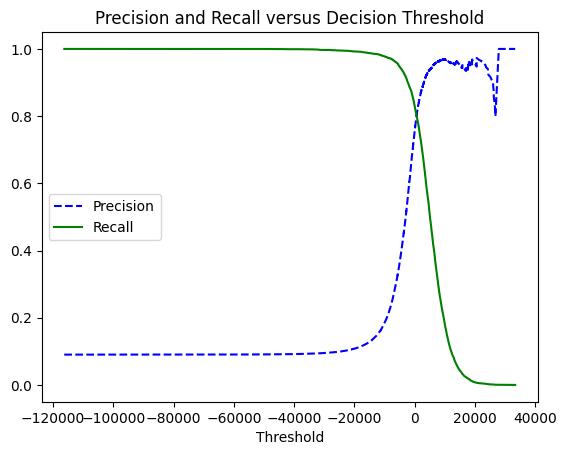

In [23]:
# Now, retrieve additional precision and retrieve data to draw precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, cv_prediction_scores)

plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.title("Precision and Recall versus Decision Threshold")
plt.legend()
plt.show()


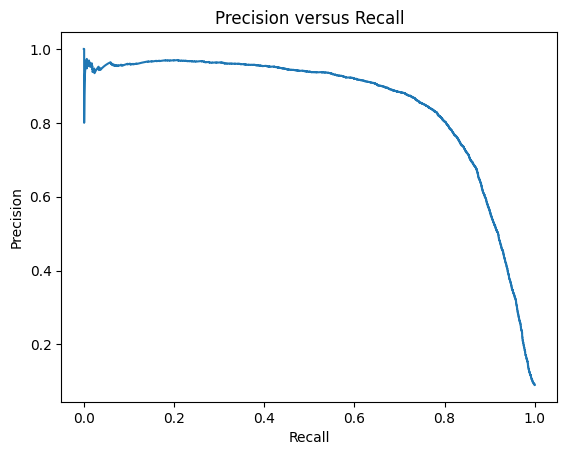

In [ ]:
# plot the precision directly against the recall

plt.plot(recalls, precisions)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision versus Recall")
plt.show()

In [25]:
expected_precision = 0.90
required_threshold = thresholds[np.argmax(precisions >= expected_precision)]

print("Required threshold for {:.0f}% percent precision is {:.3f}".format(
    expected_precision*100, required_threshold))

Required threshold for 90% percent precision is 3045.926


In [26]:
# Now, predicts with that threshold
cv_prediction_90_precision = (cv_prediction_scores >= required_threshold)

# Calculates the precision and recall
print("Precision: {:.3f}".format(precision_score(y_train_5, cv_prediction_90_precision)))
print("Recall: {:.3f}".format(recall_score(y_train_5, cv_prediction_90_precision)))

Precision: 0.900
Recall: 0.659


###The Receiver Operating Characteristic (ROC) Curve

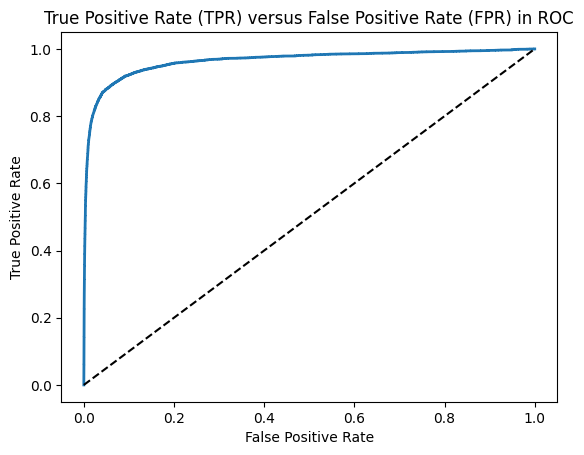

In [27]:
# Computes TRP and FPR
fpr, tpr, thresholds = roc_curve(y_train_5, cv_prediction_scores)

# Plots the ROC curve
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("True Positive Rate (TPR) versus False Positive Rate (FPR) in ROC")
plt.show()

In [28]:
# Calculates ROC AUC for SGD classifier
print("ROC AUC Score of SGD classifier: {:.3f}".format(roc_auc_score(y_train_5, cv_prediction_scores)))

ROC AUC Score of SGD classifier: 0.965


###Model Performance Comparison

In [29]:
# Initializes Random Forest classifier with default parameters
rf_clf = RandomForestClassifier(n_jobs=-1, random_state=42)

# Predicts the probabilities over cross-validation
# NOTE: This step may take several seconds to complete
cv_predictions_probas = cross_val_predict(
    rf_clf, X_train, y_train_5, cv=5, n_jobs=-1, verbose=3, method="predict_proba")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


In [31]:
# Let's consider CV prediction probability only for positive class as it is
# required to perform comparison with other classifier

cv_predictions_probas = cv_predictions_probas[:, 1]
print(cv_predictions_probas)

[0.86 0.01 0.02 ... 0.99 0.04 0.04]


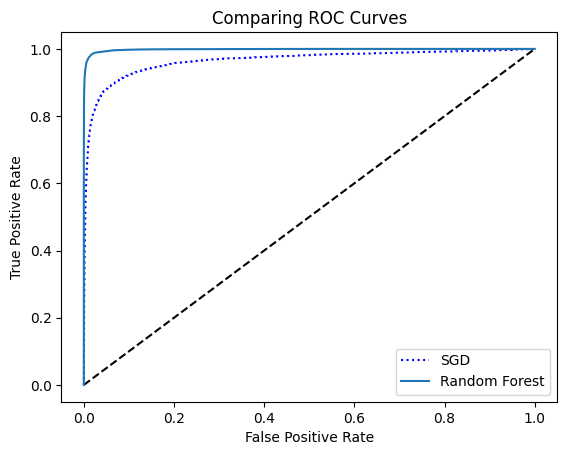

In [32]:
# Computes FPR and TPR over prediction probabilities from random forest classifier
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_train_5, cv_predictions_probas)

# Now, plots ROC curves for both the models to compare performance

plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot([0, 1], [0, 1], "k--")

plt.plot(fpr_rf, tpr_rf, label="Random Forest")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.title("Comparing ROC Curves")
plt.show()


In [33]:
# Calculates ROC AUC score of random rorest classifier
print("ROC AUC Score of Random Forest Classifier: {:.3f}".format(roc_auc_score(y_train_5, cv_predictions_probas)))

ROC AUC Score of Random Forest Classifier: 0.998


In [34]:
# Now, retrieves concrete predictions from random forest classifier
cv_predictions_rf = cv_predictions_probas >= 0.5

In [35]:
# Prints the performance summary of random forest classifier

print("Random Forest Performance Summary:\n\n" \
      "Precision: {:.3f}\nRecall: {:.3f}\nF1-Score: {:.3f}\nROC AUC Score: {:.3f}".format(
          precision_score(y_train_5, cv_predictions_rf),
          recall_score(y_train_5, cv_predictions_rf),
          f1_score(y_train_5, cv_predictions_rf),
          roc_auc_score(y_train_5, cv_predictions_probas)
))

Random Forest Performance Summary:

Precision: 0.990
Recall: 0.879
F1-Score: 0.931
ROC AUC Score: 0.998
